### Set up parameters

In [1]:
#load the %autoreload extension using the %load_ext magic command
#Then, we set the %autoreload magic command to 2, which means that modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [2]:
# dataset_name = "snps_SMALL_ref_alt"
# dataset_name = "snps"
dataset_name = "clinvar_snps"
# dataset_name = "all_snps"



# bed_file_path = "../per_RBP_transcr_BED/keep/output_" + dataset_name + ".bed"  # path to BED file
bed_file_path = "../per_RBP_transcr_BED/with_info/output_" + dataset_name + ".bed"  # path to BED file

transcript_fasta_path = "../data/hg38/transcripts.fa"  # path to transcript FASTA file
CDS_BED_PATH = '../get_fasta/run/genic_elements.cds.bed'

SNP_FASTA_FOLDER = "data_snps_fasta1"
ref_output_fasta_file_path = "{}/{}/extracted_sequences_ref.fa".format(SNP_FASTA_FOLDER, dataset_name) # path to FASTA sequences according to reference 
alt_output_fasta_file_path = "{}/{}/extracted_sequences_alt.fa".format(SNP_FASTA_FOLDER, dataset_name) # path to FASTA sequences according to VCF alternatives


In [3]:
START_CODON = 'ATG'

# FOR VARIANT AT EVERY POSITION IN THE SEQ
VARIANT_POSITION = 200
# VARIANT_POSITION = 199
CUT_POSITION_MODEL_INPUT = 100

In [4]:
FIGURES_FOLDER = 'figures/'

In [5]:
from Bio import SeqIO
import pandas as pd

In [6]:
from enum import Enum, auto

class Sequence(Enum):
    # inside the CDS region
    CDS = auto()
    # outside the CDS region
    NOT_CDS = auto()
    # transcript not in genic_elements.cds.bed file
    MISSING_RECORD = auto()

In [7]:
# Load the coding regions
# coding_regions = BedTool('../get_fasta/run/genic_elements.cds.bed')
# Load the BED file into a pandas DataFrame
cds_df = pd.read_csv(CDS_BED_PATH, sep='\t', header=None, names=['seqname', 'start', 'end', 'name', 'score', 'strand'])


def is_transcript_coords_in_cds(transcript_id, nucleotide_position, cds_df):
    # Filter: keep only reads that start in coding regions (CDS)
    # strand = '-' if read.is_reverse else '+'
    strand = '+'
    try:
        transcript_cds = cds_df[cds_df['seqname'] == transcript_id]
        cds_start = transcript_cds['start'].values[0]
        cds_end = transcript_cds['end'].values[0]
        cds_strand = transcript_cds['strand'].values[0]
    except Exception as e:
        return Sequence.MISSING_RECORD

    # Check if the start position of the read is within a coding region
    if ((nucleotide_position >= cds_start)
        and (nucleotide_position <= cds_end) 
        and (strand == cds_strand)):
        return Sequence.CDS
    return Sequence.NOT_CDS

In [8]:
def get_first_codon_atg(transcript_id, cds_df, transcripts):
    try:
        transcript_cds = cds_df[cds_df['seqname'] == transcript_id]
        cds_start = transcript_cds['start'].values[0]
        cds_end = transcript_cds['end'].values[0]
        cds_strand = transcript_cds['strand'].values[0]
    except Exception as e:
        return Sequence.MISSING_RECORD
    
    cds_first_codon = transcripts[transcript_id].seq[cds_start:cds_start+3].upper()
    first_codon_neighborhood = transcripts[transcript_id].seq[cds_start-5:cds_start+8].upper()
    
    # print(cds_first_codon == START_CODON)
    return (cds_first_codon, first_codon_neighborhood)

In [9]:
def get_distance_from_first_nt(transcript_id, cds_df, nt_position):
    try:
        transcript_cds = cds_df[cds_df['seqname'] == transcript_id]
        cds_start = transcript_cds['start'].values[0]
        cds_end = transcript_cds['end'].values[0]
        cds_strand = transcript_cds['strand'].values[0]
    except Exception as e:
        return Sequence.MISSING_RECORD
    
    distance = nt_position - cds_start
    return distance

In [12]:
transcripts = SeqIO.to_dict(SeqIO.parse(transcript_fasta_path, "fasta"))

first_nt_to_variant_distances = []

i = 0
first_codons_by_transcript = {}
first_codons = []

with open(bed_file_path, 'r') as bed_file:
    for line in bed_file:
        columns = line.strip().split('\t')
        transcript_id = columns[0]
        # FOR VARIANT AT EVERY POSITION IN THE SEQ
        start = int(columns[1])-1
        # start = int(columns[1])
        end = int(columns[2])
        ref_alt = str(columns[-1])

        if transcript_id in transcripts:
            nucleotide_position = start + VARIANT_POSITION
            tmp = is_transcript_coords_in_cds(transcript_id, nucleotide_position, cds_df)
            if tmp == Sequence.CDS:
                # print('CDS of transcript {} does NOT have ATG a first codon'.format(transcript_id))
                (codon, neighborhood) = get_first_codon_atg(transcript_id, cds_df, transcripts)
                first_codons.append(codon)
                first_codons_by_transcript[transcript_id] = (
                    codon, 
                    neighborhood, 
                    # transcript_cds['start'].values[0], 
                    # transcript_cds['end'].values[0],
                )

                distance = get_distance_from_first_nt(
                    transcript_id, 
                    cds_df, 
                    nucleotide_position,
                )
                first_nt_to_variant_distances.append(distance)
        i+=1
        if i % 3000 == 0:
            print(i)


3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000
54000
57000
60000
63000
66000
69000
72000
75000
78000
81000
84000
87000
90000
93000
96000
99000
102000
105000
108000
111000
114000
117000
120000
123000
126000
129000
132000
135000
138000
141000
144000
147000
150000
153000
156000
159000
162000
165000
168000
171000
174000
177000
180000
183000
186000
189000
192000
195000
198000
201000
204000
207000
210000
213000
216000
219000
222000
225000
228000
231000
234000
237000
240000
243000
246000
249000
252000
255000
258000
261000
264000
267000
270000
273000
276000
279000
282000
285000
288000
291000
294000
297000
300000
303000
306000
309000
312000
315000
318000
321000
324000
327000
330000
333000
336000
339000
342000
345000
348000
351000
354000
357000
360000
363000
366000
369000
372000
375000
378000
381000
384000


In [13]:
list(first_codons_by_transcript.values())[:10]

[(Seq('ATG'), Seq('ACTCTATGGTGAC')),
 (Seq('ATG'), Seq('ACTCTATGGTGAC')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA')),
 (Seq('ATG'), Seq('CGCTTATGTCCAA'))]

In [14]:
distance = first_nt_to_variant_distances[0]
frame = [(x-1) % 3 for x in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

frame

[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]

In [15]:
from utils import generate_random_dna_sequence, find_codon_frame_index
start_index = 1
plus = 3
find_codon_frame_index(start_index+plus), frame[start_index+plus]

(1, 1)

In [16]:
3%3

0

In [17]:
length=550
dna = generate_random_dna_sequence(length=length)
dna

'CCCAGTTTTGCGTCCGACTTTATTTCACTTATCTCCTGTAGATAGACTCGATCTCATGACTCGGCTCCATCTACGGGCTAGCTTAAAATTCATGGCCCCGCGTTGCCGGTCACGTTGGATAATCTATCATAGTAATCATGCAACAATTATGCTCAGGTGCTGTTCCCTAGTATGCGCATGATTAAAGCTCCCCTTTTGGGATGCCACGCCCTGGATTGTTAAGTTTCACCGGCCGCCAGGTGCAAAAACTGAGTGCCCGTTTCGATTAGCGTACTAATACGATTGACATACTTCGCTAACAGAACACGGCGCTAAATCTAACCATCGTTCCACGCCTGTCTTCTTGGTATCCTGTGTTTACCTAAGCCTTCAAGACACGAAGCTAAACCCCCCATCAACATCCCATGCGGAGGCCGGCTGGTGCCGAACTGTTTGGGAACATTTGCTGCGGATCCGGGAGGCGATACTCAGGCTTCAAAACGAGCTGAACCGATCATGCCCCATGGCCGCGTTGGTCAAGGCTATCTTTCAATATTGCGACGAGTGGCGT'

In [18]:
cds_index = 2
nt_position = 7
nt_position_relative_to_cds_start = nt_position - cds_index
frame_list = [x % 3 for x in range(len(dna))]

dna[cds_index], nt_position_relative_to_cds_start, find_codon_frame_index(nt_position), frame_list[nt_position_relative_to_cds_start]

('C', 5, 1, 2)

In [19]:
all(codon == START_CODON for codon in first_codons)

False

In [20]:
wrong_first_codon_indexes = [i for i in range(len(first_codons)) if first_codons[i] != START_CODON]

print('wrong_first_codon sequences: ', len(wrong_first_codon_indexes))
print('all sequences: ',len(first_codons))

wrong_first_codon sequences:  779
all sequences:  329410


In [21]:
# ["".join(first_codons[i]) for i in wrong_first_codon_indexes]

In [22]:
# if the neighborhood is empty, it means the CDS start is at the beginning 
# and the neighborhood size overflowed the beginning of transcript
wrong_first_codons_by_transcript = {}
for index, (transcr_id, (codon, neighborhood)) in enumerate(first_codons_by_transcript.items()):
    if codon != START_CODON:
        wrong_first_codons_by_transcript[transcr_id] = (
            "".join(codon), 
            neighborhood
            # "".join(neighborhood[0:len(neighborhood)//2]),
            # "".join(neighborhood[len(neighborhood)//2:]),
        )

In [23]:
wrong_codons = [x[0] for x in wrong_first_codons_by_transcript.values()]

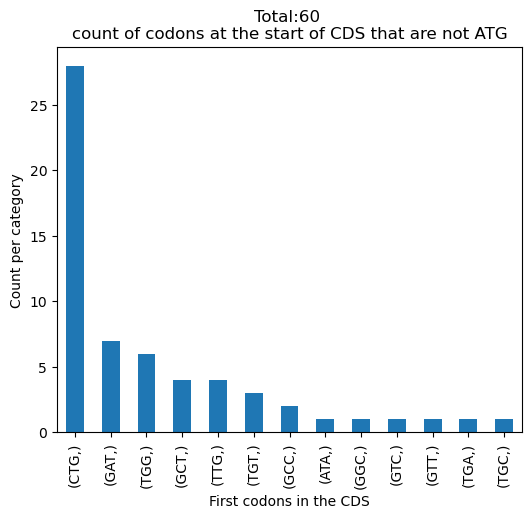

In [24]:
def get_simple_hist(df):
    result_grouped = df.value_counts()
    title = 'Total:{} \ncount of codons at the start of CDS that are not ATG'.format(df.size)

    plot = result_grouped.sort_values(ascending=False).plot(kind='bar', title = title, ylabel='Count per category',
             xlabel='First codons in the CDS', figsize=(6, 5))
    fig = plot.get_figure()
    fig.savefig(FIGURES_FOLDER + title + ".png")
    
get_simple_hist(pd.DataFrame(wrong_codons))

In [40]:
from pathlib import Path

def extract_sequences_bed_to_fasta(bed_path, transcript_path, ref_output_fasta_path, alt_output_fasta_path):
    # Load the transcripts from the FASTA file into a dictionary
    transcripts = SeqIO.to_dict(SeqIO.parse(transcript_path, "fasta"))

    sequences = []
    ref_alts = []
    alt_sequences = []
    ids_not_in_cds_bed_file = []
    variants_outside_cds = []
    first_codons = []
    cut_distances_from_first_cds_nt = []
    transcript_ids = []
    variant_position_relative_to_transcript = []
    info_collected = []
    
    Path(ref_output_fasta_path).parent.mkdir(parents=True, exist_ok=True)
    
    i = 0
    
    with open(bed_file_path, 'r') as bed_file:
    # with open(bed_file_path, 'r') as bed_file, open(ref_output_fasta_path, 'w') as ref_output_file, open(alt_output_fasta_path, 'w') as alt_output_file:
        for line in bed_file:
            columns = line.strip().split('\t')
            transcript_id = columns[0]
            # FOR VARIANT AT EVERY POSITION IN THE SEQ
            start = int(columns[1])-1
            # start = int(columns[1])
            end = int(columns[2])
            ref_alt = str(columns[6])
            info = str(columns[7])

            if transcript_id in transcripts:
                cut_nucleotide_position = start + VARIANT_POSITION
                tmp = is_transcript_coords_in_cds(transcript_id, cut_nucleotide_position, cds_df)
                if tmp == Sequence.CDS:
                    transcript_ids.append(transcript_id)
                    variant_position_relative_to_transcript.append(cut_nucleotide_position)
                    
                    sequence = transcripts[transcript_id].seq[start:end].upper()
                    sequences.append(sequence)
                    ref_alts.append(ref_alt)
                    
                    a = str(sequence)[0:VARIANT_POSITION] 
                    b = ref_alt.split('/')[1]
                    c = str(sequence)[VARIANT_POSITION + 1:]
                    alt_sequence = a + b + c
                    # alt_sequence = str(sequence)[0:VARIANT_POSITION] + ref_alt.split('/')[1] + str(sequence)[VARIANT_POSITION + 1:]
                    alt_sequences.append(alt_sequence)
                    
                    (codon, neighborhood) = get_first_codon_atg(transcript_id, cds_df, transcripts)
                    first_codons.append(codon)

                    distance = get_distance_from_first_nt(
                        transcript_id, 
                        cds_df, 
                        cut_nucleotide_position,
                    )
                    cut_distances_from_first_cds_nt.append(distance)
                    info_collected.append(info)
                    
                    # ref_output_file.write(f">{transcript_id}:{start}-{end}\n{sequence}\n")
                    # alt_output_file.write(f">{transcript_id}:{start}-{end}\n{alt_sequence}\n")
                elif tmp == Sequence.NOT_CDS:
                    variants_outside_cds.append((transcript_id, cut_nucleotide_position))
                elif tmp == Sequence.MISSING_RECORD:
                    ids_not_in_cds_bed_file.append(transcript_id)
            i+=1
            if i % 3000 == 0:
                print(i)
    print('variants outside of CDS region', len(variants_outside_cds))
    
    collected_data = [
        transcript_ids,
        sequences,
        alt_sequences,
        ref_alts,
        first_codons,
        cut_distances_from_first_cds_nt,
        variant_position_relative_to_transcript,
        info_collected,
    ]
    
    return collected_data
    # return sequences, ref_alts, alt_sequences, ids_not_in_cds_bed_file

### Run the extraction

In [41]:
from pathlib import Path

# if Path(ref_output_fasta_file_path).is_file():
#     # TODO
#     # need to get variables sequences, ref_alts, alt_sequences
#     # load ref and alt seq Fasta files - for sequences, alt_sequences
#     # save and load ref_alts as csv
#     pass
# else:

collected_data = extract_sequences_bed_to_fasta(
# sequences, ref_alts, alt_sequences, ids_not_in_cds_file = extract_sequences_bed_to_fasta(
    bed_file_path, 
    transcript_fasta_path, 
    ref_output_fasta_file_path, 
    alt_output_fasta_file_path,
)

3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
33000
36000
39000
42000
45000
48000
51000
54000
57000
60000
63000
66000
69000
72000
75000
78000
81000
84000
87000
90000
93000
96000
99000
102000
105000
108000
111000
114000
117000
120000
123000
126000
129000
132000
135000
138000
141000
144000
147000
150000
153000
156000
159000
162000
165000
168000
171000
174000
177000
180000
183000
186000
189000
192000
195000
198000
201000
204000
207000
210000
213000
216000
219000
222000
225000
228000
231000
234000
237000
240000
243000
246000
249000
252000
255000
258000
261000
264000
267000
270000
273000
276000
279000
282000
285000
288000
291000
294000
297000
300000
303000
306000
309000
312000
315000
318000
321000
324000
327000
330000
333000
336000
339000
342000
345000
348000
351000
354000
357000
360000
363000
366000
369000
372000
375000
378000
381000
384000
variants outside of CDS region 55342


In [42]:
# TODO make collected_data to a dataframe and save as pkl

collected_seq_data_pd = pd.DataFrame(
    data=collected_data, 
).transpose()

collected_seq_data_pd.columns=[
        'transcript_ids',
        'sequences',
        'alt_sequences',
        'ref_alts',
        'first_codons',
        'cut_distances_from_first_cds_nt',
        'variant_position_relative_to_transcript',
        'info',
    ]

In [43]:
collected_seq_data_pd.to_pickle("variant_sequences_details.pkl")  

In [146]:
collected_seq_data_pd_loaded = pd.read_pickle("variant_sequences_details.pkl")

In [147]:
collected_seq_data_pd_loaded.sequences = collected_seq_data_pd_loaded.sequences.map(lambda x: ''.join(x))

In [148]:
collected_seq_data_pd_loaded.first_codons = collected_seq_data_pd_loaded.first_codons.map(lambda x: ''.join(x))

In [149]:
# print('{} of variants lost because their transcript ID is not in the CDS bed file'.format(len(ids_not_in_cds_file)))
# print('{} of transcript IDs is not in the CDS bed file'.format(len(set(ids_not_in_cds_file))))

# either the CDS bed file is an older version then the variant call file (VCF)
# or those transcripts have incomplete CDS, either because their 3’ or their 5’ (or both) ends are incomplete

In [150]:
# FOR VARIANT AT EVERY POSITION IN THE SEQ
# HOTFIX - because of the change start = int(columns[1])-1, probably some starts might be -1,therefore incorectly indexing and not extracting the FASTA sequence

In [151]:
collected_seq_data_pd_loaded = collected_seq_data_pd_loaded[collected_seq_data_pd_loaded.sequences.str.len() == 401]

In [152]:
sequences = collected_seq_data_pd_loaded.sequences
alt_sequences = collected_seq_data_pd_loaded.alt_sequences 
ref_alts = collected_seq_data_pd_loaded.ref_alts

In [153]:
# for i, seq in enumerate(sequences):
    # print(seq[VARIANT_POSITION] == ref_alts[i][0], ref_alts[i][2] == alt_sequences[i][VARIANT_POSITION])
    
# check if the reference and alternative nucleotides are on a correct possition in the sequence
print(all([sequences.values[i][VARIANT_POSITION] == ref_alts.values[i][0] for i in range(len(sequences.values))]))
print(all([alt_sequences.values[i][VARIANT_POSITION] == ref_alts.values[i][2] for i in range(len(alt_sequences.values))]))
print('{} of variants found in CDS bed file and inside the CDS region'.format(len(sequences.values)))

True
True
329346 of variants found in CDS bed file and inside the CDS region


#### Shorten sequence to desired model input

In [154]:
def extract_subsequences(seq):
    """
    Given a sequence of length 401 with a special character at the index 200,
    this function outputs a list of subsequences of length 201, starting with a
    subsequence with the special character at the end and ending with a 
    subsequence with the special character at the start.
    """
    # Confirm the input is of the correct length
    if len(seq) != 401:
        raise ValueError("Input sequence must have a length of 401.")
    
    # Confirm there's a special character at index 200
    special_char = seq[200]
    
    subsequences = []
    for i in range(200, 401):
        subseq = seq[i-200:i+1]
        # Confirm the special character is in the correct position within the subsequence
        if subseq[-(i-200+1)] != special_char:
            raise ValueError("Special character not found at the expected position.")
        subsequences.append(subseq)
    
    return subsequences

# EXAMPLE / TEST
# tmp = 'a'*200 + 'X' + 'b'*200
# print(len(tmp))
# tmp = extract_subsequences(tmp)

# print(tmp[0],tmp[1], tmp[-2], tmp[-1])
# len(tmp[0]), len(tmp[-1])

# EXAMPLE / TEST
# tmp = sequences[0]
# print(len(tmp))
# tmp = extract_subsequences(tmp)

# print(tmp[0],'\n', tmp[1],'\n',  tmp[2],'\n',  tmp[3],'\n',  tmp[4])
# print(len(tmp[0]), len(tmp[-1]))

In [155]:

# VARIANT_POSITION = 200
# VARIANT_POSITION = 199
# CUT_POSITION_MODEL_INPUT = 100

# shortens seq from both sides by the same amount, the middle nucleotide stays in the middle
def shorten_seq_keep_middle(sequence, length):
    # Shorten to desired len if longer
    if len(sequence) > length:
        longer_by = len(sequence) - length
        start = longer_by//2
        # end = (len(sequence)-longer_by//2)-1
        end = (len(sequence)-longer_by//2)
        shorten_sequence = sequence[start:end]
    else:
        return sequence
    return shorten_sequence

#TEST shorten_seq_keep_middle(sequence, length)
for i in range(0,3):
    tmp = sequences[i]
    tmp_short = shorten_seq_keep_middle(tmp, 201)
    # print(len(tmp), CUT_POSITION_MODEL_INPUT, VARIANT_POSITION)

    print('lengths', len(tmp), len(tmp_short))
    print(sequences[i][VARIANT_POSITION-1:VARIANT_POSITION+2], tmp_short[CUT_POSITION_MODEL_INPUT-1:CUT_POSITION_MODEL_INPUT+2], alt_sequences[i][VARIANT_POSITION-1:VARIANT_POSITION+2])
    print()

lengths 401 201
CCC CCC CGC

lengths 401 201
CCC CCC CGC

lengths 401 201
TGT TGT TAT



In [156]:
short_sequences = [shorten_seq_keep_middle(x, 201) for x in sequences]
short_alt_sequences = [shorten_seq_keep_middle(x, 201) for x in alt_sequences]

In [157]:
print(all([short_sequences[i][CUT_POSITION_MODEL_INPUT] == ref_alts.values[i][0] for i in range(len(short_sequences))]))
print(all([short_alt_sequences[i][CUT_POSITION_MODEL_INPUT] == ref_alts.values[i][2] for i in range(len(short_alt_sequences))]))

True
True


In [158]:
len(short_sequences[0]), len(short_alt_sequences[0])

(201, 201)

In [159]:
short_seqs_count = 0
for seq_list in [short_sequences, short_alt_sequences]:
    for seq in seq_list:
        if len(seq) < 201:
            short_seqs_count +=1
short_seqs_count

0

In [160]:
collected_seq_data_pd_loaded.sequences = short_sequences
collected_seq_data_pd_loaded.alt_sequences = short_alt_sequences

In [161]:
collected_seq_data_pd_loaded.sequences.str.len()

0         201
1         201
2         201
3         201
4         201
         ... 
329405    201
329406    201
329407    201
329408    201
329409    201
Name: sequences, Length: 329346, dtype: int64

In [162]:
collected_seq_data_pd_loaded

,transcript_ids,sequences,alt_sequences,ref_alts,first_codons,cut_distances_from_first_cds_nt,variant_position_relative_to_transcript,info
0,ENST00000335137,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...,C/G,ATG,490,526,"ALLELEID=2238986;CLNDISDB=MeSH:D030342,MedGen:..."
1,ENST00000641515,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...,C/G,ATG,490,613,"ALLELEID=2238986;CLNDISDB=MeSH:D030342,MedGen:..."
2,ENST00000335137,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...,G/A,ATG,591,627,"ALLELEID=2386655;CLNDISDB=MeSH:D030342,MedGen:..."
3,ENST00000641515,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...,G/A,ATG,591,714,"ALLELEID=2386655;CLNDISDB=MeSH:D030342,MedGen:..."
4,ENST00000335137,TGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATC...,TGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATC...,T/C,ATG,678,714,"ALLELEID=2278803;CLNDISDB=MeSH:D030342,MedGen:..."
...,...,...,...,...,...,...,...,...
329405,ENST00000361567,AACAGCCCTAGACCTCAACTACCTAACCAACAAACTTAAAATAAAA...,AACAGCCCTAGACCTCAACTACCTAACCAACAAACTTAAAATAAAA...,A/G,ATA,1596,1596,"ALLELEID=680527;CLNDISDB=MONDO:MONDO:0009723,M..."
329406,ENST00000361567,ACAGCCCTAGACCTCAACTACCTAACCAACAAACTTAAAATAAAAT...,ACAGCCCTAGACCTCAACTACCTAACCAACAAACTTAAAATAAAAT...,C/T,ATA,1597,1597,"ALLELEID=680528;CLNDISDB=MONDO:MONDO:0009723,M..."
329407,ENST00000361567,GACCTCAACTACCTAACCAACAAACTTAAAATAAAATCCCCACTAT...,GACCTCAACTACCTAACCAACAAACTTAAAATAAAATCCCCACTAT...,C/T,ATA,1606,1606,"ALLELEID=680529;CLNDISDB=MONDO:MONDO:0009723,M..."
329408,ENST00000361567,CTCAACTACCTAACCAACAAACTTAAAATAAAATCCCCACTATGCA...,CTCAACTACCTAACCAACAAACTTAAAATAAAATCCCCACTATGCA...,T/C,ATA,1609,1609,"ALLELEID=680530;CLNDISDB=MONDO:MONDO:0009723,M..."


In [163]:
collected_seq_data_pd_loaded.to_pickle("variant_sequences_details.shortened_sequences.pkl")

### Evaluate sequences

#### Params

In [164]:
import numpy as np

SEED=42
np.random.seed(SEED)

K = 6
STRIDE = 1
MODEL_NAME = "simecek/DNADebertaK6c"
TOKENIZER_NAME = "armheb/DNA_bert_6"

LOAD_NAME = 'rad5cds_local.max.ds2to11_adaptive_wd0.1.pth'


#### Preprocess

In [165]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


In [166]:
def kmers_stride1(s, k=K):
    return [s[i:i + k] for i in range(0, len(s)-k+1)]

def tok_func(x): return tokenizer(" ".join(kmers_stride1(x["seq"])), truncation=True)


In [167]:
from datasets import Dataset, DatasetDict
import pandas as pd

# ref_alt_num is 0 for reference sequences and 1 for alternatives from VCF, this is only a commment, it will not be used; 
#as we do not know the label for these sequences
def tokenize_sequences(x_test, ref_alt_num):
    # function used for the actual tokenization
    tmp_dict_test = {}
    # TEST
    for index, x in enumerate(x_test):
        tmp_dict_test[f"{index}"] = ("test", ref_alt_num, x)

    df = pd.DataFrame.from_dict(tmp_dict_test).T.rename(columns = {0: "dset", 1: "cat", 2: "seq"})

    df['seq'] = [''.join(map(str, l)) for l in df['seq']]
    
    return df

In [168]:
df_ref = tokenize_sequences(short_sequences, 0)

In [169]:
df_ref.head()

,dset,cat,seq
0,test,0,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...
1,test,0,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...
2,test,0,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...
3,test,0,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...
4,test,0,TGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATC...


In [170]:
df_alt = tokenize_sequences(short_alt_sequences, 1)

In [171]:
df_alt.head()

,dset,cat,seq
0,test,1,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...
1,test,1,GGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCT...
2,test,1,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...
3,test,1,CAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAA...
4,test,1,TGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATC...


In [172]:
for seq in df_alt['seq'].tolist():
    if len(seq) < 201:
        print(len(seq), seq)

In [173]:
def tokenize(batch):
    tokenized = [tokenizer(" ".join(kmers_stride1(x)), truncation=True) for x in batch]
    grouped = {
        'input_ids':[],
        'attention_mask':[],
    }
    for seq_dict in tokenized:
        for key, seq in seq_dict.items():
            if key in ['input_ids', 'attention_mask']:
                grouped[key].append(seq)
    
    return grouped

In [174]:
import evaluate
from random import random, randrange
from transformers import AutoModelForSequenceClassification
import torch
from datasets import load_metric


binary_metrics = evaluate.combine([
    'accuracy',
    'f1',
    'recall',
    'precision',
    #Order of roc_auc matters for logging -> macro first, then weighted
    evaluate.load('roc_auc', average='macro'),
    evaluate.load('roc_auc', average='weighted'),
    evaluate.load("Vlasta/pr_auc"),
])

def compute_metrics_binary(eval_preds):
    logits, labels = eval_preds
    prediction_scores = torch.nn.functional.softmax(
        torch.from_numpy(logits).double(), dim=-1).numpy() 
    # predictions = np.argmax(logits, axis=-1) #equivalent
    predictions = np.argmax(prediction_scores, axis=-1)
    return binary_metrics.compute(
        predictions=predictions, 
        references=labels, 
        prediction_scores=prediction_scores[:,1] #taking only prediction percentage for the label 1
    )

In [175]:
num_of_labels=2
compute_metrics = compute_metrics_binary if num_of_labels == 2 else compute_metrics_multi

In [176]:
model = torch.load(LOAD_NAME)

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [178]:
from scipy.special import softmax

def batch_sequences(df, ref_alts, batch_size = 32):
    # Debug: this is just to shorten the dataset for debug purposes
    # number_of_batches = 10
    # dataframe = pd.concat([df_test.iloc[:batch_size*number_of_batches], df_test.iloc[len(df_test)-(batch_size*number_of_batches):len(df_test)]], ignore_index=False)
    # dataframe = df.iloc[:batch_size*number_of_batches]
    dataframe = df
    
    # Split sequences into batches
    num_batches = (len(dataframe['seq'].tolist()) + batch_size - 1) // batch_size
    batched_sequences = [dataframe['seq'].tolist()[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    print(
        len(batched_sequences),
        len(batched_sequences[0])
    )
    return batched_sequences


batch_size = 32
batched_sequences_ref = batch_sequences(df_ref, batch_size)
batched_sequences_alt = batch_sequences(df_alt, batch_size)

# TODO is this correct? cutting the sequence shorter from the end seems wrong
ref_alts_short = ref_alts[:len(batched_sequences_ref)*len(batched_sequences_ref[0])]

10293 32
10293 32


/tmp/ipykernel_66/2580147840.py:26: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ref_alts_short = ref_alts[:len(batched_sequences_ref)*len(batched_sequences_ref[0])]


In [179]:
# DEBUG
tmp = []
for batch in batched_sequences_alt:
    try:
        inputs = tokenize(np.array(batch))
        input_ids = torch.Tensor(inputs['input_ids']).int().to(device)
    except Exception as e: 
        tmp.append(batch)
        print(e)

In [180]:
# DEBUG
tokenized_batch = None
for batch in tmp:
    inputs = tokenize(np.array(batch))
    tokenized_batch = inputs
    for i, sample in enumerate(inputs['input_ids']):
        # print(len(sample), i)
        if len(sample) != len(inputs['input_ids'][i-1]):
            print(batch[i-1][100])
            print(batch[i][100])

# print(
#     tokenized_batch['input_ids'][10],
#     '\n',
#     '\n',
#     tokenized_batch['input_ids'][11],
#     '\n',
#     '\n',
#     np.where(tokenized_batch['input_ids'][11] == 1),
#     '\n',
#     '\n',
# )
# tmp[0][11][90:110]


In [181]:
def predict(batched_input, model, device):
    model.to(device)
    model.eval()

    # Predict in batches
    all_predictions = []
    outputs = []
    i = 0
    for batch in batched_input:
        inputs = tokenize(np.array(batch))

        input_ids = torch.Tensor(inputs['input_ids']).int().to(device)
        attention_mask = torch.Tensor(inputs['attention_mask']).int().to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        prediction_scores = torch.nn.functional.softmax(
            torch.from_numpy(logits.cpu().numpy()).double(), dim=-1).numpy() 
        predictions = prediction_scores[:,1] #taking only prediction percentage for the label 1
        all_predictions.extend(predictions)  

        i+=1
        if i % 1000 == 0:
            print(i)
            
    return all_predictions

In [182]:
ref_predictions = predict(batched_sequences_ref, model, device)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [183]:
alt_predictions = predict(batched_sequences_alt, model, device)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [184]:
len(ref_predictions), len(alt_predictions)

(329346, 329346)

In [185]:
# Create the result dataframe
# result_df = pd.DataFrame({
#     'prediction_diff': [abs(x-y) for (x,y) in zip(ref_predictions, alt_predictions)],
#     'ref_alt': ref_alts_short,
#     'ref_sequence': [seq for sublist in batched_sequences_ref for seq in sublist],
#     'ref_pred': ref_predictions,
#     'alt_sequence': [seq for sublist in batched_sequences_alt for seq in sublist],
#     'alt_pred': alt_predictions,
# })

collected_seq_data_pd_loaded['ref_pred'] = ref_predictions
collected_seq_data_pd_loaded['alt_pred'] = alt_predictions
collected_seq_data_pd_loaded['prediction_diff'] = [abs(x-y) for (x,y) in zip(ref_predictions, alt_predictions)]

In [186]:
result_path = dataset_name + '.variant_sequences_details.stats.pkl'
collected_seq_data_pd_loaded.to_pickle(result_path)

In [187]:
result_path

'clinvar_snps.variant_sequences_details.stats.pkl'

In [188]:
dataset_name

'clinvar_snps'

In [189]:
collected_seq_data_pd_loaded.sort_values('prediction_diff', ascending=False, inplace=False).round(6)

,transcript_ids,sequences,alt_sequences,ref_alts,first_codons,cut_distances_from_first_cds_nt,variant_position_relative_to_transcript,info,ref_pred,alt_pred,prediction_diff
28417,ENST00000233146,GCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCT...,GCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCT...,A/C,ATG,0,223,"ALLELEID=96307;CLNDISDB=MeSH:D003123,MedGen:C0...",0.869643,0.047000,0.822643
28419,ENST00000233146,GCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCT...,GCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCT...,A/T,ATG,0,223,"ALLELEID=96309;CLNDISDB=MeSH:D003123,MedGen:C0...",0.869643,0.060208,0.809435
223044,ENST00000544455,AAAAATTTGCCAAACGAAAATTATGGCAGGTTGTTACGAGGCATTG...,AAAAATTTGCCAAACGAAAATTATGGCAGGTTGTTACGAGGCATTG...,C/G,ATG,5745,5972,"ALLELEID=1499555;CLNDISDB=MONDO:MONDO:0003582,...",0.056945,0.835344,0.778399
223043,ENST00000380152,AAAAATTTGCCAAACGAAAATTATGGCAGGTTGTTACGAGGCATTG...,AAAAATTTGCCAAACGAAAATTATGGCAGGTTGTTACGAGGCATTG...,C/G,ATG,5745,5978,"ALLELEID=1499555;CLNDISDB=MONDO:MONDO:0003582,...",0.056945,0.835344,0.778399
114291,ENST00000508376,TGTATTGTGTTGAAGGGACACCTATAAACTTTTCCACAGCTACATC...,TGTATTGTGTTGAAGGGACACCTATAAACTTTTCCACAGCTACATC...,A/C,ATG,5021,5178,"ALLELEID=1600689;CLNDISDB=MONDO:MONDO:0021056,...",0.874237,0.121534,0.752703
...,...,...,...,...,...,...,...,...,...,...,...
35242,ENST00000540021,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,A/C,ATG,1445,1597,"ALLELEID=366542;CLNDISDB=MeSH:D003123,MedGen:C...",0.045006,0.045006,0.000000
35243,ENST00000538136,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,A/C,ATG,929,1722,"ALLELEID=366542;CLNDISDB=MeSH:D003123,MedGen:C...",0.045006,0.045006,0.000000
35244,ENST00000616033,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,A/C,ATG,1832,1915,"ALLELEID=366542;CLNDISDB=MeSH:D003123,MedGen:C...",0.045006,0.045006,0.000000
35245,ENST00000234420,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,GTTCGAGATTTAGGACTCTAGTGGCACACTATCCCCCAGTACAAGT...,A/C,ATG,1835,1987,"ALLELEID=366542;CLNDISDB=MeSH:D003123,MedGen:C...",0.045006,0.045006,0.000000
